In [30]:
import spacy
import copy
import probRobScene
import numpy as np

In [31]:
dialogue1 = ["put a table on the centre", "put a green tray on the table", "put a cube on that"]
dialogue2 = ["There is a cup on a table", "put another cup next to the first one", "it should face to the left"]
dialogue3 = ["There is a table", "put a cup on it", "put another cup on it to the left of the first cup"]

In [32]:
from ProbRobNLP import FeatureExtraction, probrob

In [33]:
special_names = {'centre':probrob.Vector3D(0, 0, 0)}

class Sentence:
    
    def __init__(self, sentence):
        self.sentence = {i: w for i, w in enumerate(FeatureExtraction.get_words_and_tags(sentence))}
        
    def get_head(self):
        for word in self.sentence.values():
            if word['id'] == word['head']:
                return word
    
    def get_children(self, id_):
        for word in self.sentence.values():
            if word['head'] == id_:
                yield word
    
    def __repr__(self):
        return '\n'.join([f"{i}: {w}"  for i, w in self.sentence.items()])
    
    
    def get_entities(self):

        sentence = list(self.sentence.values())
        for word in sentence:
            out = []
            if 'obj' in word['dep'] or 'subj' in word['dep'] or 'dative' in word['dep'] or 'attr' in word['dep']:

                for w in sentence:
                    if w['head'] == word['id'] and w['dep'] != 'acl' and w['dep'] != 'prep':
                        out.append(w)
                out.append(word)
                yield Entity(out)

    def get_semantics(self):
        word_list = copy.deepcopy(self.sentence)
        entities = self.get_entities()
        for entity in entities:
            head = entity.head
            head['word'] = str(entity)
            head['sem'] = entity.DRS
            word_list[head['id']] = head
            head['dep'] = head['dep'] + '/NP'
            word_list = {id_: word for id_, word in word_list.items() 
                          if not (word['head'] == head['id'] and word['word'] in head['word'])}
        
        for word in word_list.values():
            if word['dep'] == 'prep':
                for word2 in word_list.values():
                    if word2['head'] == word['id']:
                        assert('NP' in word2['dep'])
                        drs2 = word2['sem']
                        r1 = drs2.ref[0]
                        ref = [get_reference() + '=<dobj>', r1]
                        log = [sem(word['word'], ref)]
                        drs1 = DRSish(ref, log)
                        drs = drs1 + drs2
                             
                        word['sem'] = drs
                        word['dep'] = 'PP'
                        word['word'] = word['word'] + ' ' + word2['word']
                        word['ref'].update(word2['ref'])
                        
                        word_list = {id_: w for id_, w in word_list.items() 
                          if not (w['head'] == word['id'] and w['word'] in word['word'])}
                        
        head = self.get_head()
        dobj = None
        pp = None
        for word in word_list.values():
            if word['head'] == head['id']:
                
                if 'dobj' in word['dep']:
                    dobj = word

                elif 'PP' == word['dep']:
                    pp = word

                
                if dobj is not None and pp is not None:
                    dobj_drs = dobj['sem']
                    pp_drs = pp['sem']
                    drs = pp_drs.unify(dobj_drs)
                    
                    head['sem'] = drs
                    head['dep'] = 'S'
                    head['word'] = head['word'] + ' ' + dobj['word'] + ' ' + pp['word']
                    head['ref'].update(dobj['ref'])
                    head['ref'].update(pp['ref'])
                    
                    word_list = {id_: head if head['id'] == id_ else w for id_, w in word_list.items()}
                    
                    word_list = {id_: w for id_, w in word_list.items() 
                          if not (w['head'] == head['id'] and w['word'] in head['word'] and w['id'] != head['id'])}
        
        return word_list
                    
    
            
                
reference_id = 0
def get_reference():
    global reference_id
    x = f'x{reference_id}'
    reference_id += 1
    return x

def reset_reference():
    global reference_id
    reference_id = 0

class Entity:
    def __init__(self, wordlist):
        self.head = wordlist[-1]
        self.wordlist = wordlist
        self.DRS = self._get_semantics()
        
        
    def __repr__(self):
        return ' '.join([w['word'] for w in self.wordlist])
    
    def get_semantics(self):
        return self.DRS
    
    def _get_semantics(self):
        og = copy.deepcopy(self)
        ref = []
        log = []
        for word in self.wordlist:
            if word['pos'] == 'DET':
                reference = get_reference()
                if word['word'] == 'a':
                    pass
                elif word['word'] == 'the' or word['word'] == 'that':
                    reference = reference + '=?'
                ref.append(reference)
            else:
                log.append(sem(word['word'], [reference]))
        
        if len(log) ==1 and log[0].name in special_names:
            ref = [special_names[log[0].name]]
            log = []
        
        head = self.wordlist[-1]
        role = head['dep']
        head['ref'][reference] = og
        return DRSish(ref, log, role=role)

class DRSish:
    
    def __init__(self, ref, log, role=None):
        self.ref = ref
        self.log = log
        self.role = role
        
    def __repr__(self):
        return str(self.ref) + str(self.log) + ' r: ' + str(self.role)
    
    def __add__(self, other):
        ref = list(set(self.ref + other.ref))
        log = self.log + other.log
        return DRSish(ref, log)
    
    def get_predicates(self, reference):
        assert(reference in self.ref)
        
        for l in self.log:
            if reference in l.refs:
                yield l
                
    def get_first_predicates(self, reference):
        assert(reference in self.ref)
        
        for l in self.log:
            if reference == l.refs[0]:
                yield l
    
    def unify(self, other):

        new_ref = []
        log = copy.deepcopy(self.log)
        assert(len(other.ref) == 1)
        for ref in self.ref:

            if isinstance(ref, str) and '<' in ref:

                hole = ref.split('<')[1].strip('>')
                if hole == other.role:
                    new_ref.append(other.ref[0])
                    new_log = []
                    for formula in log:
                        if ref in formula.refs:
                            refs = [other.ref[0] if r == ref else r for r in formula.refs]
                            new_log.append(sem(formula.name, refs))
                        else:
                            new_log.append(formula)
                    log = new_log
            else:
                new_ref.append(ref)
        new_ref = [r for r in new_ref if isinstance(r, str)]
        return DRSish(new_ref, log + other.log, self.role)
    
    def replace_reference(self, hole, antecedent):
        new_ref = [r for r in self.ref if r != hole] + ([antecedent] if antecedent not in self.ref else [])
        log = copy.deepcopy(self.log)
        new_log = []
        for l in log:
            if hole in l.refs:
                refs = [r if r != hole else antecedent for r in l.refs]
                new_log.append(sem(l.name, refs))
            else:
                new_log.append(l)
        self.ref = new_ref
        self.log = list(set(new_log))
    
    def to_PRS(self):
        order = self.order_prs()
        entities = {entity.name: entity for entity in self._to_PRS()}
        for name in order:
            yield entities[name]
    
    def remove_predicate(self, p):
        self.log = [l for l in self.log if p != l]
        
    def remove_reference(self, ref):
        self.ref = [r for r in self.ref if r != ref]
    
    def _to_PRS(self):
        types = {'tray':'Tray', 'cup': 'Cup', 'bowl':'Bowl', 'bucket':'Bucket', 
                     'chair':'DiningChair', 'filled_cup':'FilledCup',
                     'plate':'Plate', 'table':'Table', 'robot':'Robot', 'camera':'Camera', 'peg':'HexagonalPegBase',
                     'gear':'HexagonalGear', 'cube':'Cube', 'toy_cube':'ToyCube', 'cylinder':'Cylinder', 'rope link':'RopeLink',
                     'rope bucket':'RopeBucket', 'conveyor belt':'CircularConveyorBelt'}
            
        two_place = {'on':probrob.OnConstraint, 'in':probrob.OnConstraint}
            
        colour_dict = {'red':'"0.1"', 'blue':'"0.2"', 'green':'"0.3"', 'grey':'"0.4"', 'orange':'"0.5"', 'purple':'"0.7"', 'pink':'"0.6"', 'black':'"0"', 'white':'"1"'}
            


        # for l in self.log:
        #     if l.name in special_names:
        #         self.remove_predicate(l)
        #         self.replace_reference(l.refs[0], l.name)
        #         self.remove_reference(l.name)

        for ref in self.ref:

            preds = self.get_first_predicates(ref)    
            
            constraints = []
            type_ = None
            for pred in preds:
                if pred.name in types:
                    type_ = types[pred.name]
                elif pred.name in two_place: 
                    constraints.append(two_place[pred.name](pred.refs[1] if pred.refs[1] not in special_names else special_names[pred.refs[1]]))
                elif pred.name in colour_dict:
                    constraints.append(probrob.PropConstraint('color', f'"{pred.name}"'))
                    
            if type_ is not None:
                yield probrob.Entity(type_, ref, constraints)
            else:
                print(f'Warning: {ref} identified as type None')
     
    def order_prs(self):
        constraints = []
        for entity in self._to_PRS():
            for constraint in entity.constraints:
                try:
                    r = constraint.referent
                    constraints.append((r, entity.name))
                except AttributeError:
                    pass

        constraint_dict = {}
        for entity in self._to_PRS():
            c = [d for (d, i) in constraints if i == entity.name and d in self.ref]
            constraint_dict[entity.name] = c

        order = []
        print(constraint_dict)
        while len(constraint_dict) > 0:
            new_dict = {}
            for name, cons in constraint_dict.items():
                if cons == [] or all([x in order for x in cons]):
                    order.append(name)
                else:
                    new_dict[name] = cons
            constraint_dict = new_dict
        return order
        
    
    def draw(self):
        prs_lines = self.to_PRS()
        imp = probrob.Import('model', '*')
        scene = probrob.WorldModel(prs_lines, [imp])
        return scene
    
    def test_reference_matches(self, reference, constraints):
        
        preds = [c.name for c in self.get_first_predicates(reference)]
        # print('reference', reference, 'preds', preds, 'constraints', constraints)
        # print(all([c.name in preds for c in constraints]))
        return all([c.name in preds for c in constraints])
        
    
class sem:
    def __init__(self, name, refs):
        self.name = name
        self.refs = refs    
    
    def __repr__(self):
        return f'{str(self.name)}({", ".join(map(str, self.refs))})'
    
    def __eq__(self, other):
        return self.name == other.name and self.refs == other.refs
            
    def __hash__(self):
        # hash(custom_object)
        return hash((self.name, ' '.join(map(str, self.refs))))

In [34]:
def generate_images(scenario_file):
    scenario = probRobScene.scenario_from_file(scenario_file)

    max_generations = 9
    rejections_per_scene = []
    for i in range(max_generations):
        # print(f"Generation {i}")
        ex_world, used_its = scenario.generate(verbosity=2)
        rejections_per_scene.append(used_its)
        ex_world.show_3d(save_location=f"test{i}.png")
   #
    avg_rejections = np.average(rejections_per_scene)


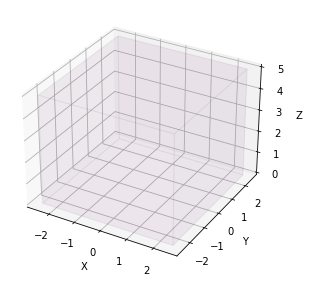

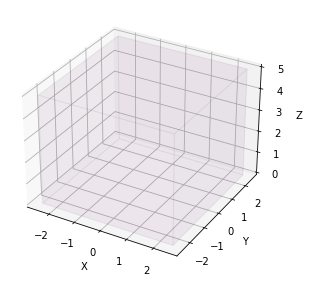

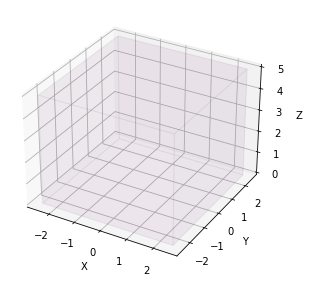

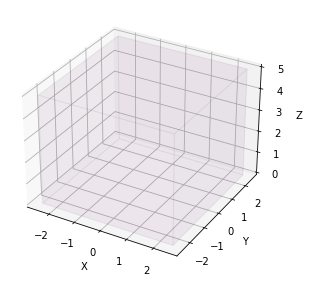

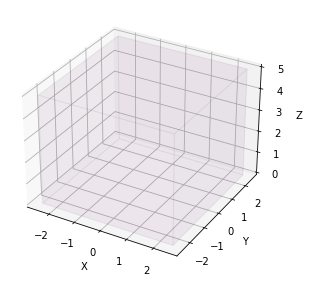

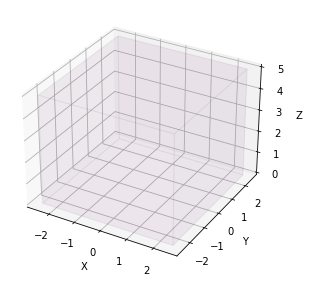

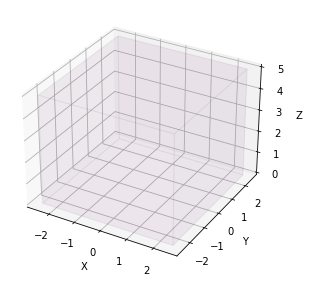

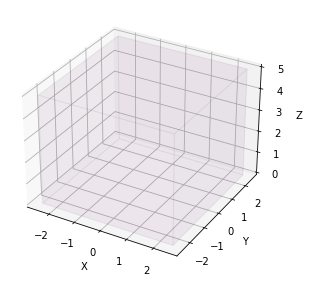

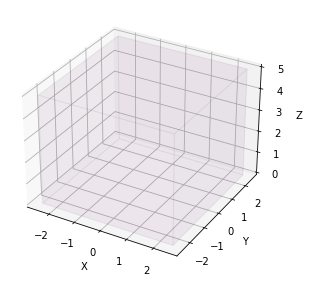

In [39]:
d = "from model import *"
with open('tmp.prs', 'w') as f:
    f.write(d)
generate_images('tmp.prs')

In [35]:
class Dialogue:
    
    def __init__(self):
        reset_reference()
        self.current_state = None
        self.refs = {}
        self.dialogue_history = []
        
    def read_sentence(self, sentence):
        sentence = Sentence(sentence)

        
        
        drs_sent = sentence.get_semantics()
        
        
        
        self.refs.update(drs_sent[0]['ref'])
        
        self.dialogue_history.append((sentence, drs_sent[0]))
        
        print(self.refs)
        # print(drs_sent)
        
        assert(len(drs_sent) == 1)
        
        drs = drs_sent[0]['sem']
        
        if self.current_state is None:
            self.current_state = drs
        else:
            self.current_state = self.current_state + drs
        
        if any(['?' in r for r in filter(lambda x: isinstance(x, str), self.current_state.ref)]):
            unresolved = [r for r in self.current_state.ref if '?' in r]
            
            print('unresolved', unresolved)
            
            for r in unresolved:
                
                
                constraints = list(self.current_state.get_first_predicates(r))
                
                candidates = [ref for ref in self.current_state.ref if self.current_state.test_reference_matches(ref, constraints) and ref != r]
                
                print('candidates', candidates)
                if len(candidates) == 1:
                    replacement = candidates[0]
                    self.current_state.replace_reference(r, replacement)
                    self.dialogue_history[-1][1]['ref'][replacement] = self.dialogue_history[-1][1]['ref'][r]
                else:
                    best_candidate = None
                    best_candidate_time = -1
                
                    for candidate in candidates:
                        if best_candidate is None:
                            # print('default candidate', candidate)
                            best_candidate = candidate
                            best_candidate_time = self.get_time_diff(candidate, r)
                            best_candidate_features = FeatureExtraction.feature_vector(dlg.refs[candidate].wordlist, dlg.refs[r].wordlist)
                        else:
                            time_diff = self.get_time_diff(candidate, r)
                            features = FeatureExtraction.feature_vector(dlg.refs[candidate].wordlist, dlg.refs[r].wordlist)
                            # print('trying candidate', candidate)
                            # print('time diff', time_diff)
                            # print('direct object target', features['direct_object_antecedent'])
                            # print('candidate direct object', best_candidate_features['direct_object_antecedent'])
                            if features['direct_object_antecedent'] is True:
                                
                                if (time_diff <= best_candidate_time or best_candidate_features['direct_object_antecedent'] is False) and time_diff != 0:
                                    best_candidate = candidate
                                    best_candidate_time = time_diff
                                    best_candidate_features = features
                                    
                    print(best_candidate, r)
                    self.current_state.replace_reference(r, best_candidate)
                    self.dialogue_history[-1][1]['ref'][best_candidate] = self.dialogue_history[-1][1]['ref'][r]
                        
                        # print(candidate, r, self.get_time_diff(candidate, r))
                        # print(FeatureExtraction.feature_vector(dlg.refs[candidate].wordlist, dlg.refs[r].wordlist))
                        
                        
                        
                        
                    # raise NotImplementedError("not implemented how to resolve situations with more than one candidate")
                
            
    def get_time_diff(self, ref1, ref2):
        time1 = 0
        time2 = 0
        
        for i, (_, d) in enumerate(self.dialogue_history):
            if ref1 in d['ref']:
                time1 = i
            if ref2 in d['ref']:
                time2 = i
        return time2 - time1
        
        
        
    def draw(self):
        prs_data = str(self.current_state.draw())
        with open('tmp.prs', 'w') as f:
            f.write(prs_data)

        print(prs_data)
        generate_images('tmp.prs')



{'x0': a blue table, 'x1=?': the centre}
{'x0': a blue table, 'x1=?': the centre, 'x3': a green tray, 'x4=?': the table}
unresolved ['x4=?']
candidates ['x0']
{'x0': a blue table, 'x1=?': the centre, 'x3': a green tray, 'x4=?': the table, 'x6': a red cube, 'x7=?': that}
unresolved ['x7=?']
candidates ['x0', 'x3', 'x6']
x3 x7=?
{'x0': a blue table, 'x1=?': the centre, 'x3': a green tray, 'x4=?': the table, 'x6': a red cube, 'x7=?': that, 'x9': a tray, 'x10=?': the table}
unresolved ['x10=?']
candidates ['x0']
{'x0': a blue table, 'x1=?': the centre, 'x3': a green tray, 'x4=?': the table, 'x6': a red cube, 'x7=?': that, 'x9': a tray, 'x10=?': the table, 'x12': a orange cube, 'x13=?': the tray}
unresolved ['x13=?']
candidates ['x3', 'x9']
x9 x13=?
{'x6': ['x3'], 'x12': ['x9'], 'x3': ['x0'], 'x0': [], 'x9': ['x0']}
from model import *
x0 = Table with color "blue", on Vector3D(0, 0, 0)
x9 = Tray on x0
x12 = Cube with color "orange", on x9
x3 = Tray with color "green", on x0
x6 = Cube on x3,

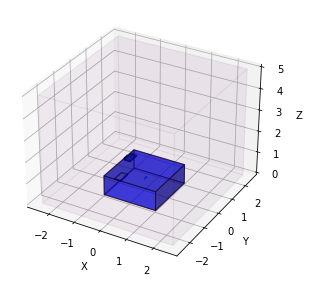

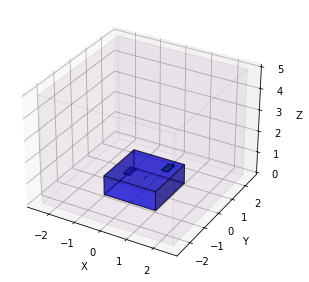

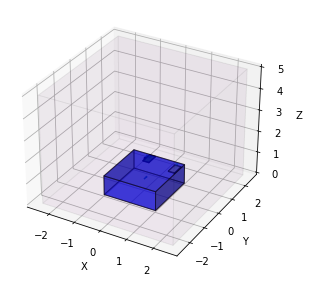

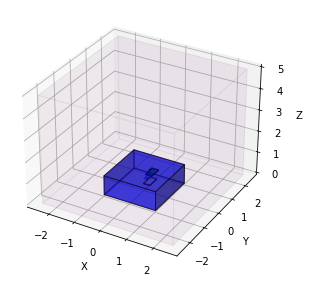

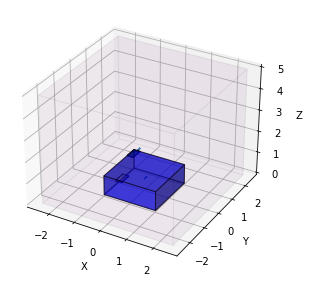

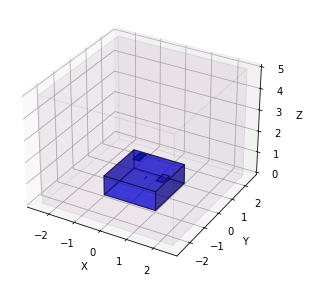

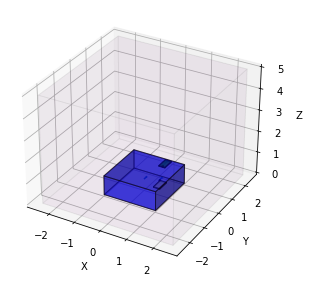

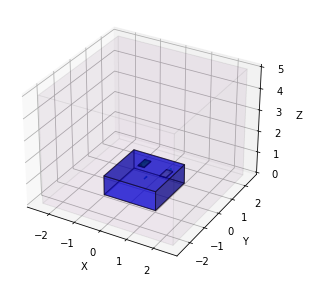

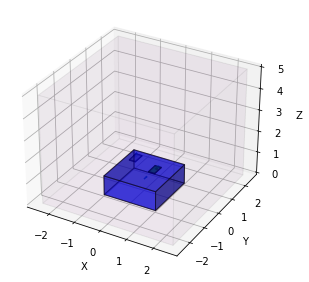

In [36]:

dialogue1 = ["put a table on the centre", "put a green tray on the table", "put a cube on that"]
dlg = Dialogue()

dlg.read_sentence("put a blue table on the centre")

# dlg.draw()

dlg.read_sentence("put a green tray on the table")

# dlg.draw()

dlg.read_sentence("put a red cube on that")

# dlg.draw()

dlg.read_sentence("put a tray on the table")

dlg.read_sentence("put a orange cube on the tray")

dlg.draw()

In [49]:
FeatureExtraction.feature_vector(dlg.refs['x0'].wordlist, dlg.refs['x3'].wordlist)

{'exact_match': False,
 'substring_match': False,
 'word_overlap': True,
 'edit_distance': False,
 'ant_definite': False,
 'tar_defnite': False,
 'proper_noun': True,
 'pronoun_antecedent': False,
 'pronoun_target': False,
 'subject': True,
 'direct_object': True,
 'indirect_object': True,
 'number_match': True}

In [ ]:


reset_reference()
d11 = Sentence(dialogue1[0])

drs0_sent = d11.get_semantics()
# print(drs0_sent)
drs0 = drs0_sent[0]['sem']

print('drs0', drs0)

d12 = Sentence(dialogue1[1])

drs1_sent = d12.get_semantics()
# print(drs1_sent)

drs1 = drs1_sent[0]['sem']

print('drs1', drs1)

drs01 = drs0 + drs1
drs01.replace_reference('x4=?', 'x0')
print('drs 0-1', drs01)

d11 = Sentence(dialogue1[2])

drs2_sent = d11.get_semantics()
# print(drs2_sent)

drs2 = drs2_sent[0]['sem']


print('drs2', drs2)


drs02 = drs01 + drs2

drs02.replace_reference('x7=?', 'x3')

print(drs02)
prs_data = str(drs02.draw())
print(prs_data)
with open('tmp.prs', 'w') as f:
    f.write(prs_data)

generate_images('tmp.prs')

In [184]:

order

['x1', 'x0', 'x3']

In [68]:
try:
    print(a.constraints[0].referent)
except AttributeError:
    print("no referent")

x1


In [40]:
on_x1 = probrob.OnConstraint('x1=?')
colour_green = probrob.PropConstraint('color', 'green')
probrob.Entity('Tray', 'x0', constraints=[on_x1, colour_green])

x0 = Tray on x1=?, with color green

In [122]:
get_reference()

'x0'

In [44]:
d11 = Sentence(dialogue1[0])
d11

0: {'id': 0, 'word': 'there', 'tag': 'EX', 'dep': 'expl', 'pos': 'PRON', 'head': 1}
1: {'id': 1, 'word': 'is', 'tag': 'VBZ', 'dep': 'ROOT', 'pos': 'AUX', 'head': 1}
2: {'id': 2, 'word': 'a', 'tag': 'DT', 'dep': 'det', 'pos': 'DET', 'head': 3}
3: {'id': 3, 'word': 'table', 'tag': 'NN', 'dep': 'attr', 'pos': 'NOUN', 'head': 1}
4: {'id': 4, 'word': 'in', 'tag': 'IN', 'dep': 'prep', 'pos': 'ADP', 'head': 3}
5: {'id': 5, 'word': 'the', 'tag': 'DT', 'dep': 'det', 'pos': 'DET', 'head': 6}
6: {'id': 6, 'word': 'centre', 'tag': 'NN', 'dep': 'pobj', 'pos': 'NOUN', 'head': 4}

In [45]:
d11.get_semantics()

{0: {'id': 0,
  'word': 'there',
  'tag': 'EX',
  'dep': 'expl',
  'pos': 'PRON',
  'head': 1},
 1: {'id': 1,
  'word': 'is',
  'tag': 'VBZ',
  'dep': 'ROOT',
  'pos': 'AUX',
  'head': 1},
 3: {'id': 3,
  'word': 'a table',
  'tag': 'NN',
  'dep': 'attr/NP',
  'pos': 'NOUN',
  'head': 1,
  'sem': ['x0'][table(x0)] r: attr},
 4: {'id': 4,
  'word': 'in the centre',
  'tag': 'IN',
  'dep': 'PP',
  'pos': 'ADP',
  'head': 3,
  'sem': ['x2=<dobj>', 'x1=?'][in(x2=<dobj>, x1=?), centre(x1=?)] r: None}}

In [46]:
ent = list(d11.get_entities())
print(ent[0].get_semantics())
print(ent[1].get_semantics())
print(ent[0].get_semantics() + ent[1].get_semantics())

['x3'][a table(x3)] r: attr/NP
['x4=?'][the centre(x4=?)] r: pobj/NP
['x4=?', 'x3'][a table(x3), the centre(x4=?)] r: None


In [126]:
S <- VB NP PP

SyntaxError: invalid syntax (<ipython-input-126-ff805f49ee93>, line 1)

In [7]:
d12 = Sentence(dialogue1[1])
print(d12)
list(d12.get_entities())
d12.get_semantics()

0: {'id': 0, 'word': 'put', 'tag': 'VB', 'dep': 'ROOT', 'pos': 'VERB', 'head': 0}
1: {'id': 1, 'word': 'a', 'tag': 'DT', 'dep': 'det', 'pos': 'DET', 'head': 3}
2: {'id': 2, 'word': 'green', 'tag': 'JJ', 'dep': 'amod', 'pos': 'ADJ', 'head': 3}
3: {'id': 3, 'word': 'tray', 'tag': 'NN', 'dep': 'dobj', 'pos': 'NOUN', 'head': 0}
4: {'id': 4, 'word': 'on', 'tag': 'IN', 'dep': 'prep', 'pos': 'ADP', 'head': 0}
5: {'id': 5, 'word': 'the', 'tag': 'DT', 'dep': 'det', 'pos': 'DET', 'head': 6}
6: {'id': 6, 'word': 'table', 'tag': 'NN', 'dep': 'pobj', 'pos': 'NOUN', 'head': 4}


{0: {'id': 0,
  'word': 'put',
  'tag': 'VB',
  'dep': 'ROOT',
  'pos': 'VERB',
  'head': 0},
 3: {'id': 3,
  'word': 'a green tray',
  'tag': 'NN',
  'dep': 'dobj/NP',
  'pos': 'NOUN',
  'head': 0,
  'sem': ['x2'][green(x2), tray(x2)]},
 4: {'id': 4,
  'word': 'on the table',
  'tag': 'IN',
  'dep': 'PP',
  'pos': 'ADP',
  'head': 0,
  'sem': ['x3=?', 'x4=??'][on(x4=??, x3=?), table(x3)]}}

In [119]:
d13 = Sentence(dialogue1[2])
print(d13)
list(d13.get_entities())

0: {'id': 0, 'word': 'put', 'tag': 'VB', 'dep': 'ROOT', 'pos': 'VERB', 'head': 0}
1: {'id': 1, 'word': 'a', 'tag': 'DT', 'dep': 'det', 'pos': 'DET', 'head': 2}
2: {'id': 2, 'word': 'cube', 'tag': 'NN', 'dep': 'dobj', 'pos': 'NOUN', 'head': 0}
3: {'id': 3, 'word': 'on', 'tag': 'IN', 'dep': 'prep', 'pos': 'ADP', 'head': 0}
4: {'id': 4, 'word': 'that', 'tag': 'DT', 'dep': 'pobj', 'pos': 'DET', 'head': 3}


[a cube, that]

In [22]:
dialogue1_parsed = [d11, d12, d13]

In [23]:
for i, d in enumerate(dialogue1_parsed):
    print(i, d.get_head())

0 {'id': 1, 'word': 'is', 'tag': 'VBZ', 'dep': 'ROOT', 'pos': 'AUX', 'head': 1}
1 {'id': 0, 'word': 'put', 'tag': 'VB', 'dep': 'ROOT', 'pos': 'VERB', 'head': 0}
2 {'id': 0, 'word': 'put', 'tag': 'VB', 'dep': 'ROOT', 'pos': 'VERB', 'head': 0}
